# CNN from scratch

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
#sklearn libraries
from sklearn import metrics, preprocessing, model_selection, ensemble
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0
Running on TPU  ['10.116.23.98:8470']


In [ ]:
#tensorflow libraries
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.utils import to_categorical,np_utils
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

## Functions

In [ ]:
def plot_graph(histo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(histo.history['accuracy'])
    axs[0].plot(histo.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='best')

    axs[1].plot(histo.history['loss'])
    axs[1].plot(histo.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='best')


    plt.show()

In [ ]:
def plot_cm(model,x_test,labels_te,name):
  y_pred=model.predict(x_test)
  y_pred_class = np.argmax(y_pred,axis = 1)
  y_true=np.argmax(labels_te,axis=1)
  scores=model.evaluate(x_test,labels_te,verbose=1)
  print("Accuracy: %.2f%%" % (scores[1]*100))
  cm = confusion_matrix(y_true, y_pred_class)
  f,ax = plt.subplots(figsize=(15, 15))
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix "+name)
  plt.show()



## Load data

### Train data

In [ ]:
df_train = pd.read_csv("sign_mnist_train.csv")
df_train.shape

(27455, 785)

<Axes: >

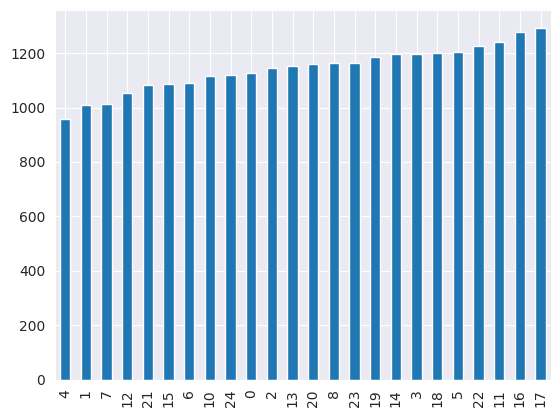

In [ ]:
y_train=df_train.label
y_train.value_counts().sort_values().plot(kind='bar')

In [ ]:
x_train=df_train.drop(['label'], axis=1)
x_train=x_train/255.0
x_train.shape

(27455, 784)

### Test data

In [ ]:
df_test = pd.read_csv("sign_mnist_test.csv")
df_test.shape

(7172, 785)

<Axes: >

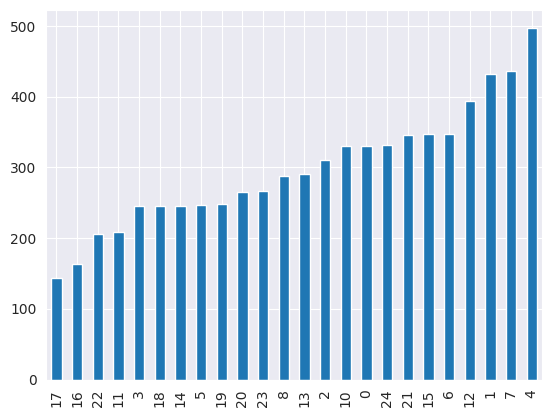

In [ ]:
y_test=df_test.label
y_test.value_counts().sort_values().plot(kind='bar')

In [ ]:
x_test=df_test.drop(['label'], axis=1)
x_test=x_test/255.0
x_test.shape

(7172, 784)

## Data Engineering

### Reshape data

In [ ]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)
x_train.shape,x_test.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

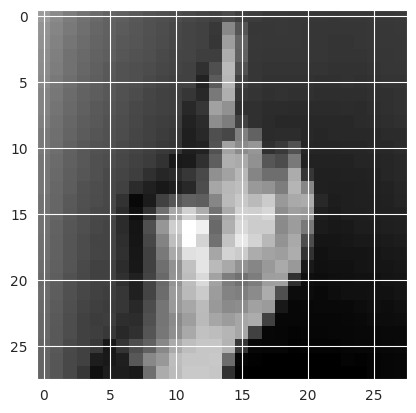

In [ ]:
plt.imshow(x_train[0],  cmap=plt.cm.binary)

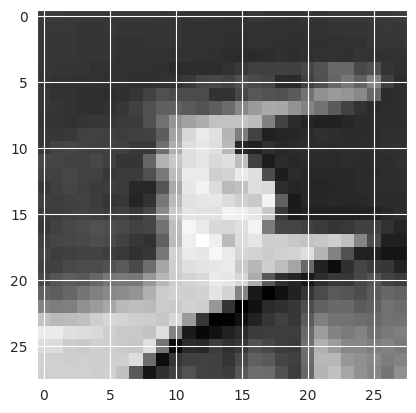

In [ ]:
plt.imshow(x_test[0], cmap=plt.cm.binary)

### Split train data
train_x, train_y, val_x, val_y

In [ ]:
train_x, val_x,train_y, val_y = train_test_split(x_train, y_train,
                                                 test_size=0.3, random_state=28)

In [ ]:
train_x.shape,train_y.shape,val_x.shape,val_y.shape

((19218, 28, 28, 1), (19218,), (8237, 28, 28, 1), (8237,))

### One hot encoding on Labels

In [ ]:
#number of categories
print(y_test.nunique())

24


In [ ]:
n_classes=24

In [ ]:
#size of images
print(x_train.shape, x_test.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


In [ ]:
label_binarizer = LabelBinarizer()

In [ ]:
#train labels
labels_tr = label_binarizer.fit_transform(train_y)
labels_tr

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#validation labels
labels_val = label_binarizer.fit_transform(val_y)
labels_val

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# labels
labels_te = label_binarizer.fit_transform(y_test)
labels_te

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
labels_tr.shape, labels_val.shape, labels_te.shape

((19218, 24), (8237, 24), (7172, 24))

## CNN From Scratch Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation = 'relu'))
model.add(Dropout(0.20))

model.add(Dense(n_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer = 'adam',
               metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 32)         0

In [ ]:
histo = model.fit(train_x, labels_tr, validation_data = (val_x, labels_val),
                  epochs = 20, verbose = 1)

Epoch 1/20
601/601 [==============================] - 13s 20ms/step - loss: 2.1207 - accuracy: 0.3317 - val_loss: 0.8601 - val_accuracy: 0.7080
Epoch 2/20
601/601 [==============================] - 11s 19ms/step - loss: 0.6740 - accuracy: 0.7614 - val_loss: 0.3491 - val_accuracy: 0.8822
Epoch 3/20
601/601 [==============================] - 12s 19ms/step - loss: 0.3122 - accuracy: 0.8916 - val_loss: 0.1368 - val_accuracy: 0.9602
Epoch 4/20
601/601 [==============================] - 11s 19ms/step - loss: 0.1595 - accuracy: 0.9463 - val_loss: 0.0584 - val_accuracy: 0.9849
Epoch 5/20
601/601 [==============================] - 11s 19ms/step - loss: 0.0992 - accuracy: 0.9671 - val_loss: 0.0359 - val_accuracy: 0.9913
Epoch 6/20
601/601 [==============================] - 11s 19ms/step - loss: 0.0676 - accuracy: 0.9788 - val_loss: 0.0378 - val_accuracy: 0.9920
Epoch 7/20
601/601 [==============================] - 11s 19ms/step - loss: 0.0419 - accuracy: 0.9879 - val_loss: 0.0261 - val_accuracy:

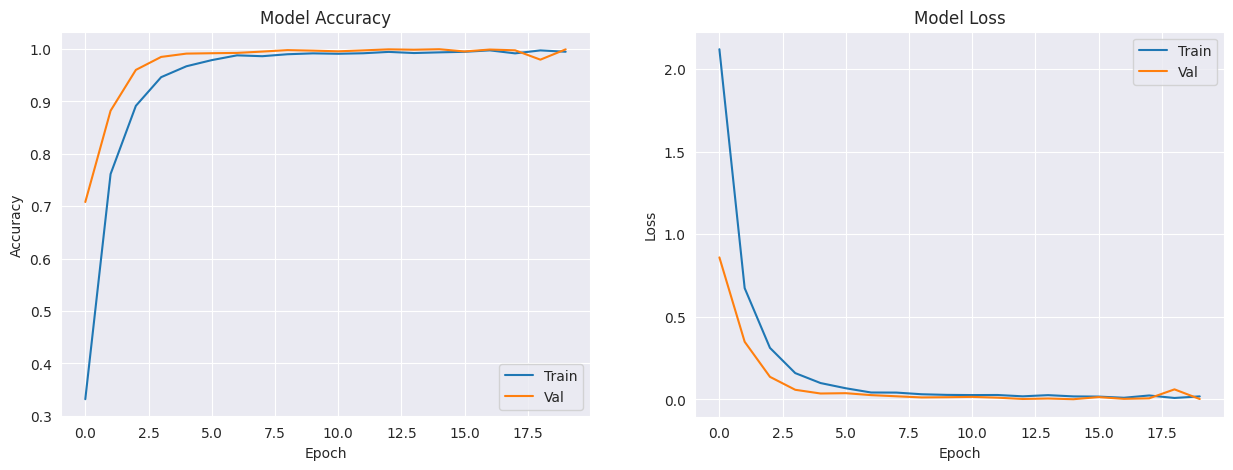

In [ ]:
plot_graph(histo)

225/225 [==============================] - 2s 9ms/step - loss: 0.4877 - accuracy: 0.9021
Accuracy: 90.21%


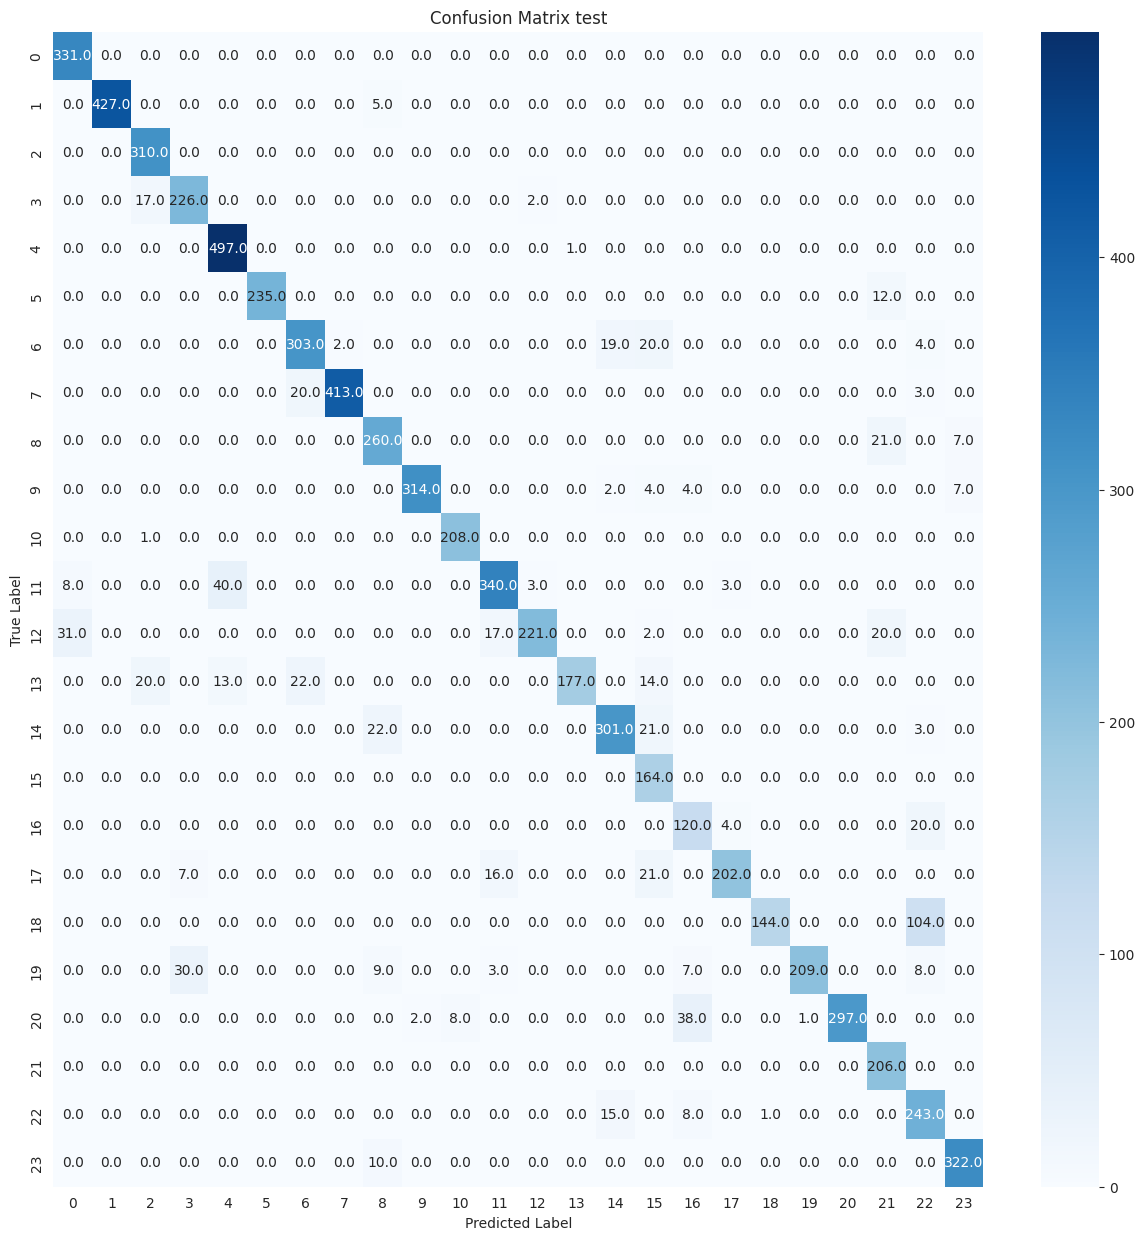

In [ ]:
#Confusion Matrix test
plot_cm(model,x_test,labels_te,"test")